# FLI with compositional score matching


In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.special import expit
from tqdm import tqdm

from bayesflow import diagnostics

from torch.utils.data import DataLoader

from diffusion_model import HierarchicalScoreModel, SDE, euler_maruyama_sampling, adaptive_sampling, train_score_model
from diffusion_model.helper_networks import GaussianFourierProjection, ShallowSet
from diffusion_model.bayesflow_summary_nets import TimeSeriesNetwork
from problems.fli import FLIProblem, FLI_Prior, generate_synthetic_data
from problems import plot_shrinkage, visualize_simulation_output

When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [2]:
torch_device = torch.device("mps")

In [3]:
prior = FLI_Prior()
batch_size = 64
number_of_obs = [4]
max_number_of_obs = number_of_obs if isinstance(number_of_obs, int) else max(number_of_obs)

current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][1]
)

dataset = FLIProblem(
    n_data=10000,
    prior=prior,
    sde=current_sde,
    online_learning=True,
    number_of_obs=number_of_obs,
)

dataset_valid = FLIProblem(
    n_data=1000,
    prior=prior,
    sde=current_sde,
    number_of_obs=number_of_obs
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

for test in dataloader:
    print(test[0].shape)
    print(test[2].shape)
    print(test[4].shape)
    break

Kernel type: variance_preserving, noise schedule: cosine
t_min: 0.00035210439818911254, t_max: 0.999647855758667
alpha, sigma: (tensor(1.0000), tensor(0.0006)) (tensor(0.0006), tensor(1.0000))
torch.Size([64, 6])
torch.Size([64, 4, 3])
torch.Size([64, 4, 256, 1])


In [9]:
# Define diffusion model
n_blocks = [5,6][0]
hidden_dim = [256, 512][0]
hidden_dim_summary = [10, 14, 18, 22, 32][0]
split_summary_vector = [True, False][1]
#n_blocks, hidden_dim, hidden_dim_summary, split_summary_vector = list(itertools.product(n_blocks, hidden_dim, hidden_dim_summary, split_summary_vector))[0]

summary_net = TimeSeriesNetwork(input_dim=1, recurrent_dim=256, summary_dim=hidden_dim_summary)

global_summary_dim = hidden_dim_summary
global_summary_net = ShallowSet(dim_input=hidden_dim_summary, dim_output=global_summary_dim, dim_hidden=128)

time_embedding_local = nn.Sequential(
    GaussianFourierProjection(8),
    nn.Linear(8, 8),
    nn.Mish()
)
time_embedding_global = nn.Sequential(
    GaussianFourierProjection(8),
    nn.Linear(8, 8),
    nn.Mish()
)

score_model = HierarchicalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_theta_local=prior.n_params_local,
    input_dim_x_global=global_summary_dim,
    input_dim_x_local=hidden_dim_summary,
    summary_net=summary_net,
    global_summary_net=global_summary_net if isinstance(number_of_obs, list) else None,
    #time_embedding_local=time_embedding_local,
    #time_embedding_global=time_embedding_global,
    hidden_dim=hidden_dim,
    n_blocks=n_blocks,
    max_number_of_obs=max_number_of_obs,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior,
    name_prefix=f'FLI_{max_number_of_obs}_{hidden_dim_summary}_{hidden_dim}_{n_blocks}{"_split" if split_summary_vector else ""}_{summary_net.name}_',
    split_summary_vector=split_summary_vector
)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|       summary_net.enc.0.weight       |    1280    |
|        summary_net.enc.0.bias        |    128     |
|       summary_net.enc.2.weight       |   16384    |
|        summary_net.enc.2.bias        |    128     |
|       summary_net.enc.4.weight       |   16384    |
|        summary_net.enc.4.bias        |    128     |
|       summary_net.enc.6.weight       |   16384    |
|        summary_net.enc.6.bias        |    128     |
|       summary_net.dec.0.weight       |   16384    |
|        summary_net.dec.0.bias        |    128     |
|       summary_net.dec.2.weight       |   16384    |
|        summary_net.dec.2.bias        |    128     |
|       summary_net.dec.4.weight       |   16384    |
|        summary_net.dec.4.bias        |    128     |
|       summary_net.dec.6.weight       |    1280    |
|        summary_net.dec.6.b

In [ ]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid, hierarchical=True,
                                              epochs=3000, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(16, 4), tight_layout=True)
plt.plot(loss_history[:, 0], label='Training', color="#132a70", lw=2.0, alpha=0.9)
plt.plot(loss_history[:, 1], label='Validation', linestyle="--", marker="o", color='black')
plt.grid(alpha=0.5)
plt.xlabel('Training epoch #')
plt.ylabel('Value')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')

In [10]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", map_location=torch_device, weights_only=True))
score_model.eval();

# Validation

In [11]:
n_local_samples = 10
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(prior=prior, n_data=100,
                                                                            n_local_samples=n_local_samples,
                                                                            random_seed=0)
n_post_samples = 100
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(n_local_samples)
#score_model.current_number_of_obs = 4  # we can choose here, how many observations are passed together through the score
score_model.current_number_of_obs = max_number_of_obs
print(valid_data.shape, score_model.current_number_of_obs)

torch.Size([100, 10, 256, 1]) 4


In [12]:
t1_value = 0.1
t0_value = 1
sampling_arg = {
    'size': 2,
    #'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    'sampling_chunk_size': 512,
    'noisy_condition': {
        'apply': False,
        'noise_scale': 0.1,
        'tau_1': 0.6,
        'tau_2': 0.8,
        'mixing_factor': 1.
    },
}
#plt.plot(torch.linspace(0, 1, 100), sampling_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()

t0_value, t1_value

(1, 0.1)

In [13]:
#score_model.sde.s_shift_cosine = 4
# posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, obs_n_time_steps=obs_n_time_steps,
#                                                    n_post_samples=n_post_samples,
#                                                    #sampling_arg=sampling_arg,
#                                                    run_sampling_in_parallel=False,
#                                                    device=torch_device, verbose=True)

posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                         n_post_samples=n_post_samples,
                                                         sampling_arg=sampling_arg,
                                                         diffusion_steps=100, device=torch_device, verbose=True)

100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


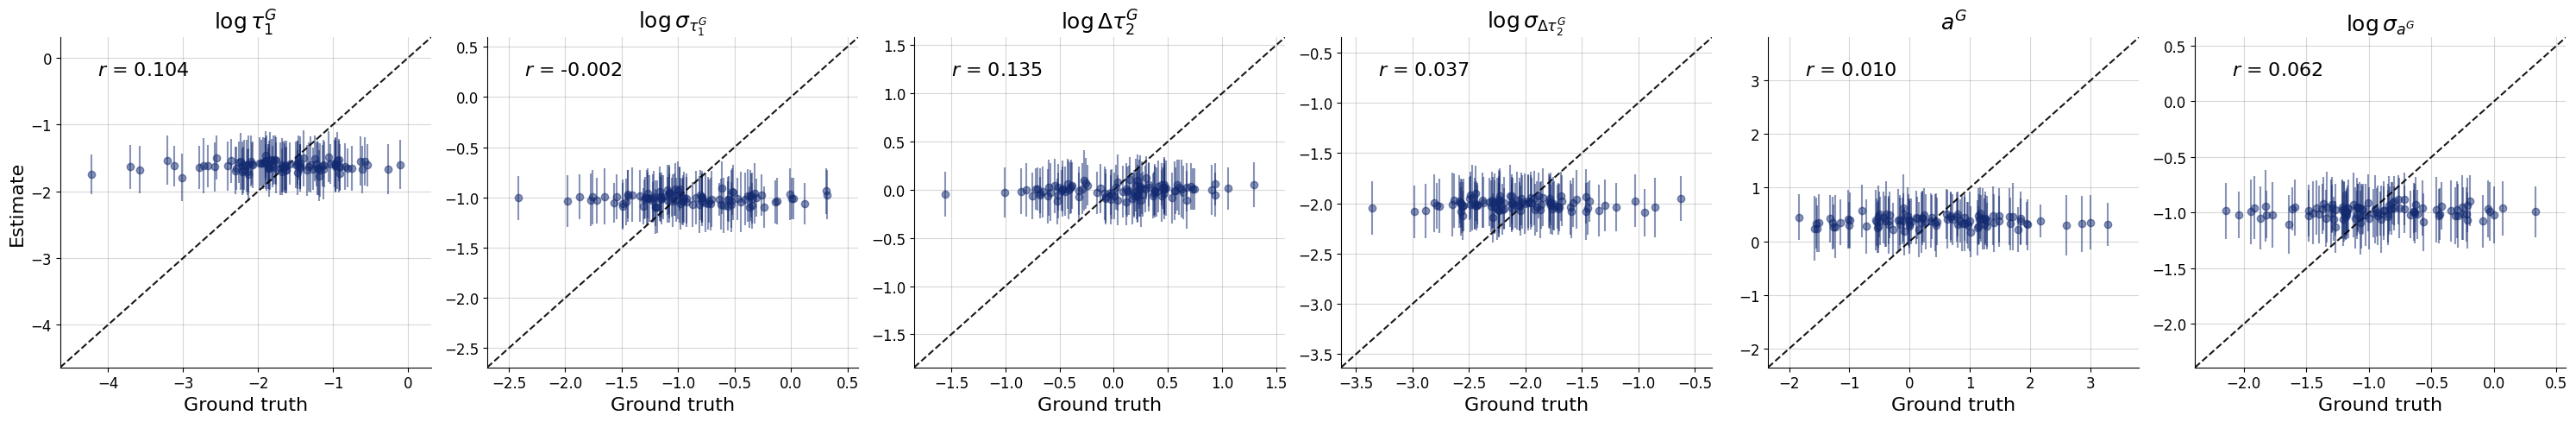

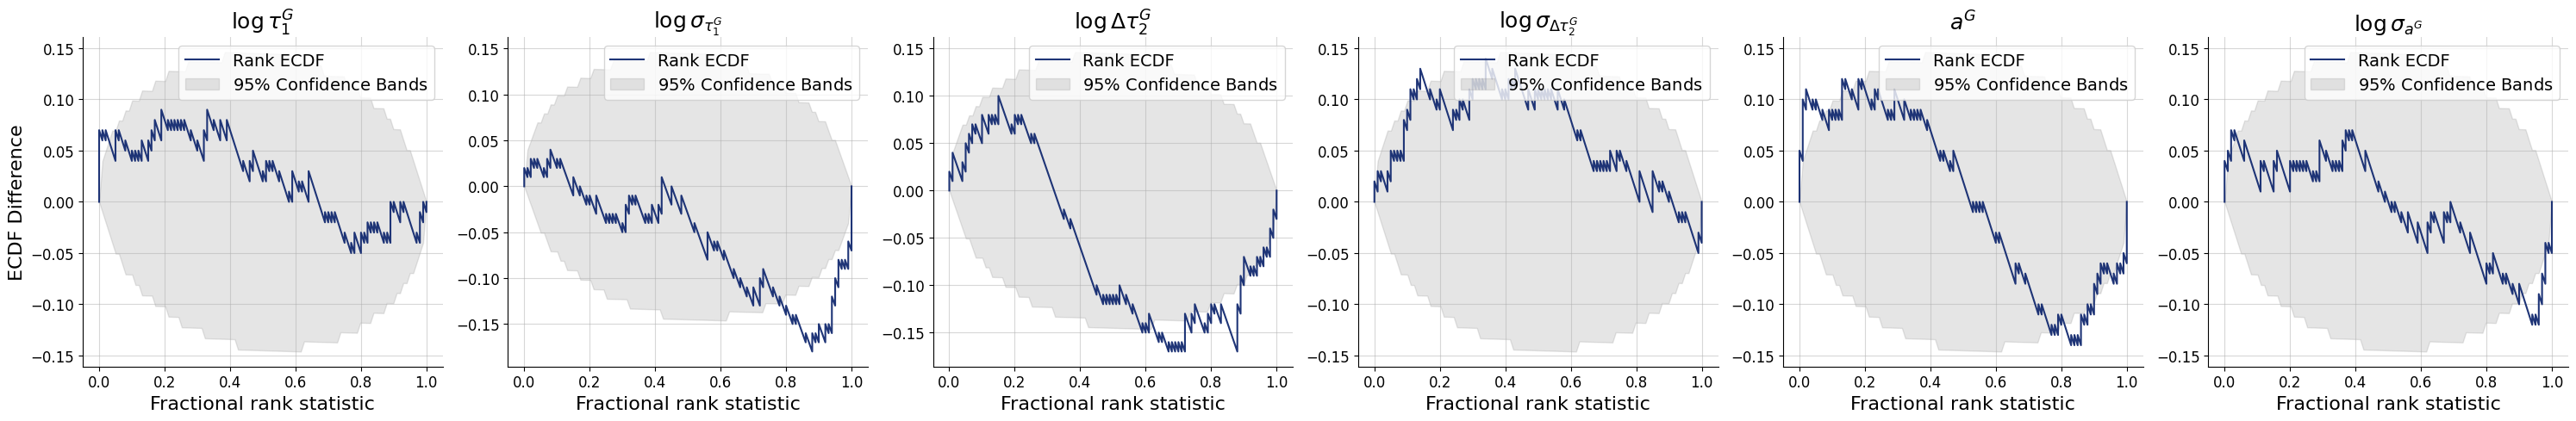

In [14]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
#fig.savefig(f'plots/{score_model.name}/recovery_global.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
#fig.savefig(f'plots/{score_model.name}/ecdf_global.png')

In [ ]:
score_model.sde.s_shift_cosine = 0
score_model.current_number_of_obs = 1
posterior_local_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                        n_post_samples=n_post_samples, conditions=posterior_global_samples_valid,
                                                        diffusion_steps=50, device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          variable_names=local_param_names)
#fig.savefig(f'plots/{score_model.name}/recovery_local.png')

In [ ]:
plot_shrinkage(posterior_global_samples_valid[:12], posterior_local_samples_valid[:12], min_max=(-10, 10))

In [ ]:
valid_id = 0
print('Global Estimates')
print('mu:', np.median(posterior_global_samples_valid[valid_id, :, 0]), np.std(posterior_global_samples_valid[valid_id, :, 0]))
print('log sigma:', np.median(posterior_global_samples_valid[valid_id, :, 1]), np.std(posterior_global_samples_valid[valid_id, :, 1]))
print('True')
print('mu:', valid_prior_global[valid_id][0].item())
print('log sigma:', valid_prior_global[valid_id][1].item())

In [ ]:
n_grid = int(np.sqrt(n_local_samples))
ps = posterior_local_samples_valid[valid_id, :, :n_grid*n_grid].reshape(n_post_samples, n_grid, n_grid, 3).copy()
true = valid_prior_local[valid_id, :n_grid*n_grid].numpy().copy().reshape(n_grid, n_grid, 3)
ps[:, :, :, 0] = np.exp(ps[:, :, :, 0])
true[:, :, 0] = np.exp(true[:, :, 0])
ps[:, :, :, 1] = ps[:, :, :, 0] + np.exp(ps[:, :, :, 1])
true[:, :, 1] = true[:, :, 0] + np.exp(true[:, :, 1])
ps[:, :, :, 2] = expit(ps[:, :, :, 2])
true[:, :, 2] = expit(true[:, :, 2])
transf_local_param_names = [r'$\tau_1^L$', r'$\tau_2^L$', r'$A^L$']

med = np.median(ps, axis=0)
std = np.std(ps, axis=0)
error = (med-true)**2
visualize_simulation_output(med, title_prefix=['Posterior Median ' + p for p in transf_local_param_names],
                            cmap='turbo', save_path=f"plots/{score_model.name}/simulation_median_{valid_id}.png")
visualize_simulation_output(true, title_prefix=['True ' + p for p in transf_local_param_names],
                            cmap='turbo', save_path=f"plots/{score_model.name}/simulation_true_{valid_id}.png")

visualize_simulation_output(std, title_prefix=['Posterior Std ' + p for p in transf_local_param_names],
                            cmap='turbo', save_path=f"plots/{score_model.name}/simulation_std_{valid_id}.png")
visualize_simulation_output(error, title_prefix=['Error ' + p for p in transf_local_param_names],
                            cmap='turbo', save_path=f"plots/{score_model.name}/simulation_error_{valid_id}.png")

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for i in range(3):
    ax[i].errorbar(x=true[:, :, i].flatten(), y=med[:, :, i].flatten(), yerr=1.96*std[:, :, i].flatten(), fmt='o')
    #ax[i].plot([np.min(true[:, :, i]), np.max(true[:, :, i])], [np.min(true[:, :, i]), np.max(true[:, :, i])], 'k--')
    ax[i].axhline(np.median(posterior_global_samples_valid[valid_id, :, i], axis=0), color='red', linestyle='--',
                label='Global posterior mean', alpha=0.75)
    ax[i].set_ylabel('Prediction')
    ax[i].set_xlabel('True')
    ax[i].legend()
plt.show()

 # Apply the Model to Real Data

In [15]:
global_param_names = prior.global_param_names

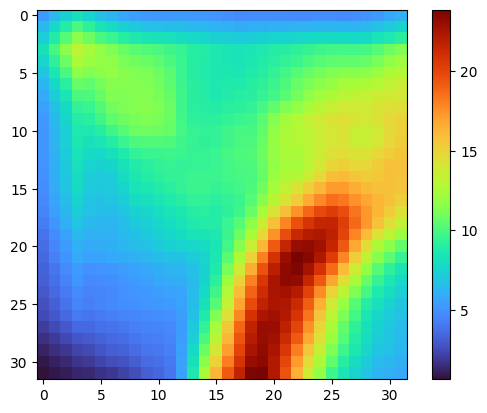

In [17]:
grid_data = 32
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(grid_data * grid_data)

binned_data = np.load('problems/FLI/exp_binned_data.npy')[:grid_data, :grid_data]
real_data = binned_data.reshape(1, grid_data * grid_data, 256, 1) / np.max(binned_data)

plt.imshow(np.mean(binned_data, axis=-1), cmap='turbo')
plt.colorbar()
#plt.savefig('plots/FLI_exp_binned_data.png')
plt.show()

In [ ]:
t1_value = 0.01
t0_value = 1
n_post_samples = 100
sampling_arg = {
    'size': 10,
    ##'damping_factor': lambda t: (torch.ones_like(t) / real_data.shape[1] * 100) * (t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t)),
    #'damping_factor': lambda t: (1-torch.ones_like(t)) / real_data.shape[1] + 0.1,
    'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
}
score_model.sde.s_shift_cosine = 3.5

In [ ]:
1/real_data.shape[1]

In [ ]:
real_data.shape

In [ ]:
posterior_global_samples_real = euler_maruyama_sampling(score_model, real_data,
                                                         n_post_samples=n_post_samples,
                                                         sampling_arg=sampling_arg,
                                                         diffusion_steps=300, device=torch_device, verbose=True)

In [ ]:
prior_dict = {}
posterior_dict = {}
prior_tranf_dict = {}
posterior_tranf_dict = {}
for i in range(len(global_param_names)):
    prior_dict[global_param_names[i]] = valid_prior_global[:, i]
    posterior_dict[global_param_names[i]] = posterior_global_samples_real[0, :, i]

tau, tau_2, A = prior.transform_raw_params(
        log_tau=prior_dict[global_param_names[0]],
        log_delta_tau=prior_dict[global_param_names[2]],
        a=prior_dict[global_param_names[4]]
    )
prior_tranf_dict = {
    r'$\tau$': tau,
    r'$\tau_2$': tau_2,
    r'$A$': A
}

tau, tau_2, A = prior.transform_raw_params(
        log_tau=posterior_dict[global_param_names[0]],
        log_delta_tau=posterior_dict[global_param_names[2]],
        a=posterior_dict[global_param_names[4]]
    )
posterior_tranf_dict = {
    r'$\tau$': tau,
    r'$\tau_2$': tau_2,
    r'$A$': A
}

In [ ]:
fig = diagnostics.pairs_posterior(
    posterior_dict,
    priors=prior_dict,
)
#fig.savefig(f'plots/real_data_global_posterior.png')

#fig = diagnostics.pairs_posterior(
#    posterior_tranf_dict,
#    priors=prior_tranf_dict,
#)
#fig.savefig(f'plots/real_data_global_posterior_transf.png')

In [ ]:
conditions = posterior_global_samples_real

In [ ]:
chunk_size = 2048
score_model.sde.s_shift_cosine = 0

posterior_local_samples_real = {'log_tau_L': [], 'log_delta_tau_L': [], 'a_l': []}
for start_idx in tqdm(range(0, grid_data**2, chunk_size)):
    end_idx = min(start_idx + chunk_size, grid_data**2)
    posterior_samples_chunk = euler_maruyama_sampling(score_model, real_data[:, start_idx:end_idx],
                                                        conditions=conditions,
                                                        n_post_samples=n_post_samples,
                                                        diffusion_steps=100, device=torch_device, verbose=False)

    for i_k, k in enumerate(posterior_local_samples_real.keys()):
        posterior_local_samples_real[k].append(posterior_samples_chunk[0, :, :, i_k])

for k in posterior_local_samples_real.keys():
    posterior_local_samples_real[k] = np.concatenate(posterior_local_samples_real[k], axis=1)

In [ ]:
tau, tau_2, A = prior.transform_raw_params(
    log_tau=posterior_local_samples_real['log_tau_L'].T.reshape(n_post_samples, grid_data, grid_data),
    log_delta_tau=posterior_local_samples_real['log_delta_tau_L'].T.reshape(n_post_samples, grid_data, grid_data),
    a=posterior_local_samples_real['a_l'].T.reshape(n_post_samples, grid_data, grid_data),
)
ps = np.concatenate([tau[:, :, :, np.newaxis], tau_2[:, :, :, np.newaxis], A[:, :, :, np.newaxis]], axis=-1)
transf_local_param_names = [r'$\tau_1^L$', r'$\tau_2^L$', r'$A^L$']

med = np.median(ps, axis=0)
std = np.std(ps, axis=0)
visualize_simulation_output(med, title_prefix=['Posterior Median ' + p for p in transf_local_param_names],
                            cmap='turbo')#, save_path=f"plots/real_data_median.png")
visualize_simulation_output(std, title_prefix=['Posterior Std ' + p for p in transf_local_param_names],
                            cmap='turbo')#, save_path=f"plots/real_data_std.png")

In [ ]:
fig, axis = plt.subplots(1, 5, figsize=(10, 3), tight_layout=True, sharex=True, sharey=True)
axis = axis.flatten()
pixel_ids = [0, 0]
for ax in axis:
    plot_index = np.random.randint(0, tau.shape[0])

    simulations = np.array([
        prior.simulator.decay_gen_single(
            tau_L=tau[post_index, pixel_ids[0], pixel_ids[1]],
            tau_L_2=tau_2[post_index, pixel_ids[0], pixel_ids[1]],
            A_L=A[post_index, pixel_ids[0], pixel_ids[1]]
        ) for post_index in range(tau.shape[0])
    ])

    ax.plot(real_data.reshape(grid_data, grid_data, 256)[pixel_ids[0], pixel_ids[1]], label='data')
    ax.plot(np.median(simulations, axis=0), label='posterior median', alpha=0.8, color='orange')
    ax.fill_between(
        np.arange(simulations.shape[1]),
        np.quantile(simulations, 0.025, axis=0),
        np.quantile(simulations, 0.975, axis=0),
        alpha=0.4,
        color='orange',
        label='posterior 95% CI'
    )
    ax.set_xlabel('Time')
axis[0].set_ylabel('Normalized Photon Count')
fig.legend(labels=['data', 'posterior median', 'posterior 95% CI'], bbox_to_anchor=(0.5, -0.07),
           ncol=3, loc='lower center')
#plt.savefig(f'plots/real_data_fit.png')
plt.show()